In [1]:
library(MASS)
library(dplyr)
library(readr)
library(pracma)
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=3)


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
df <- readr::read_csv('data/heightWeightData.txt', col_names=c('gender', 'height', 'weight'), col_types='nnn') %>%
        mutate(gender = as.factor(gender))

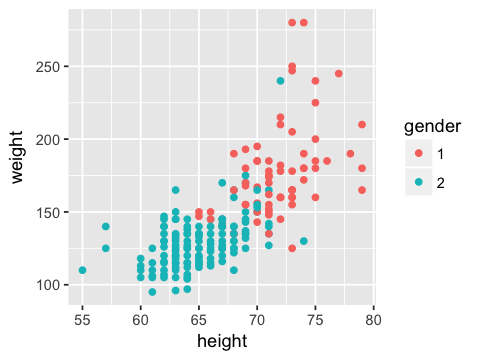

In [3]:
ggplot(df, aes(x=height, y=weight, color=gender)) +
    geom_point()

In [4]:
# This is the function we will use for computing the misclassification rate
misclass <- function(y, yhat) {
    ys <- cbind(y=y, yhat=yhat) %>%
            as.data.frame() %>%
            mutate(y = as.numeric(y), yhat = as.numeric(yhat)) %>%
            mutate(missed = (yhat != y)) %>%
            `$`('missed') %>%
            mean(na.rm=TRUE)
    print(paste0('Misclassification rate: ', (ys * 100), '%'))
}

In [5]:
# This is using the LDA function already defined in R
fit <- lda(gender ~ height + weight, data=df)
misclass(df$gender, predict(fit, df)$class)

[1] "Misclassification rate: 11.9047619047619%"


In [6]:
# Here I will implement LDA myself using the equations in section 4.2.3
lda.fit <- function(formula, train) {
    # Extract the X and the y
    y <- train[, all.vars(formula)[1]]
    X <- train[, all.vars(formula)[-1]]
    
    # Following the equations from section 4.2.3
    sigma.inv <- solve(cov(X))
    mu0 <- as.matrix(colMeans(X[y == 1, ]))
    mu1 <- as.matrix(colMeans(X[y == 2, ]))
    w <- sigma.inv %*% (mu1 - mu0)
    prior.factor <- (mu1 - mu0) %*% ((log(mean(y == 2) / mean(y == 1))) / (t(mu1 - mu0) %*% sigma.inv %*% (mu1 - mu0)))
    x0 <- (0.5 * (mu1 + mu0)) - prior.factor
    
    # Use these fitted values to predict
    yhat <- sigmoid(as.matrix(sweep(X, 2, x0, `-`)) %*% w)
    return((yhat >= 0.5) + 1)
}

yhat <- lda.fit(gender ~ height + weight, train=df)
misclass(df$gender, yhat)

[1] "Misclassification rate: 12.8571428571429%"


In [7]:
# This is using the LDA function already defined in R
fit <- qda(gender ~ height + weight, data=df)
misclass(df$gender, predict(fit, df)$class)

[1] "Misclassification rate: 11.9047619047619%"


In [8]:
# Implementing QDA from Section 4.2.1
qda.fit <- function(formula, train) {
    # Extract the X and the y
    y <- train[, all.vars(formula)[1]]
    X <- train[, all.vars(formula)[-1]]
    
    pi0 <- mean(y == 1)
    pi1 <- mean(y == 2)
    mu0 <- as.matrix(colMeans(X[y == 1, ]))
    mu1 <- as.matrix(colMeans(X[y == 2, ]))
    sigma0 <- cov(X[y == 1,])
    sigma1 <- cov(X[y == 2,])
    norm0 <- pi0*(det(2*pi*sigma0)^(-.5))
    norm1 <- pi1*(det(2*pi*sigma1)^(-.5))
    Xmu0 <- as.matrix(sweep(X, 2, mu0, `-`))
    Xmu1 <- as.matrix(sweep(X, 2, mu1, `-`))
    
    single.point <- function(idx) {
        quant0 <- norm0 * exp(-0.5 * t(as.matrix(Xmu0[idx, ])) %*% solve(sigma0) %*% as.matrix(Xmu0[idx, ]))
        quant1 <- norm1 * exp(-0.5 * t(as.matrix(Xmu1[idx, ])) %*% solve(sigma1) %*% as.matrix(Xmu1[idx, ]))
        prob <- quant1 / (quant0 + quant1)
        return(prob)
    }
    
    yhat <- sapply(seq(nrow(X)), single.point)
    yhat <- (yhat >= 0.5) + 1
    return(yhat)
}

yhat <- qda.fit(gender ~ height + weight, train=df)
misclass(df$gender, yhat)

[1] "Misclassification rate: 11.9047619047619%"
